# Progetto - Applicazioni Data Intensive 2021 
####Gennari Riccardo

Link codice sorgente:
https://drive.google.com/file/d/1KDs8hK0KR_I4C-pL37ycgMu3Kp6QLD5b/view?usp=sharing

Il progetto ha lo scopo di creare un modello predittivo che possa determinare la polarità di una recensione, basandosi sul suo testo. 

## Setup

Cominciamo importando alcune librerie e funzioni che useremo in seguito.

In [403]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import nltk
from joblib import dump, load
from imblearn.pipeline import Pipeline
from seaborn import heatmap
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
nltk.download("stopwords")
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Riccardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Riccardo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Usiamo Pandas per ottenere il dataset (.csv) che useremo per il progetto.

In [32]:
raw_data = pd.read_csv("https://bitbucket.org/GennariR/progetto/raw/5e43964c1c085d5878fb60928c20758823a27be2/Reviews.csv", sep=",",
                       usecols=["Id","ProductId","UserId", "HelpfulnessNumerator", "HelpfulnessDenominator", "Score", "Summary", "Text"],
                       encoding='latin-1')

raw_data.set_index("Id", inplace=True)

## Analisi Esplorativa

Vediamo quali sono le caratteristiche di questo dataset.

In [33]:
raw_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568454 entries, 1 to 568454
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ProductId               568454 non-null  object
 1   UserId                  568454 non-null  object
 2   HelpfulnessNumerator    568454 non-null  int64 
 3   HelpfulnessDenominator  568454 non-null  int64 
 4   Score                   568454 non-null  int64 
 5   Summary                 568427 non-null  object
 6   Text                    568454 non-null  object
dtypes: int64(3), object(4)
memory usage: 403.0 MB


Abbiamo più di 500000 recensioni Amazon, riguardanti cibi di vario tipo. Di seguito il significato delle colonne:

- **ProductId** - id del prodotto recensito
- **UserId** - id dell'utente che ha scritto la recensione
- **HelpfulnessNumerator** - n utenti che ha trovato la recensione utile
- **HelpfulnessDenominator** - n totale di utenti che ha votato se la recensione è utile o meno
- **Score** - rating da 1 a 5
- **Summary** - riassunto della recensione
- **Text** - testo completo della recensione

500000 recensioni sono un numero elevato: per alleggerire i tempi di calcolo e l'uso di memoria consideriamo solo le prime 25000. Anche così ridotto, il numero di campioni dovrebbe essere più che sufficiente per ottenere un buon modello. Rimuoviamo anche eventuali record nulli.

In [34]:
raw_data = raw_data.head(25000).dropna()
raw_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 1 to 25000
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ProductId               25000 non-null  object
 1   UserId                  25000 non-null  object
 2   HelpfulnessNumerator    25000 non-null  int64 
 3   HelpfulnessDenominator  25000 non-null  int64 
 4   Score                   25000 non-null  int64 
 5   Summary                 25000 non-null  object
 6   Text                    25000 non-null  object
dtypes: int64(3), object(4)
memory usage: 17.8 MB


Siamo passati da più di 400mb a 18. Ora il dataset è molto più piccolo, ma possiamo comunque specificare i tipi di dato delle colonne per renderne più chiaro il contenuto, e per risparmiare un altro pò di spazio.

In [35]:
pd.DataFrame([raw_data.min(numeric_only=True).rename("Min"), raw_data.max(numeric_only=True).rename("Max")]).T

Min  Max
HelpfulnessNumerator      0  202
HelpfulnessDenominator    0  219
Score                     1    5

Ad esempio, vediamo che il range dei valori di queste colonne è molto inferiore rispetto a quello di un int64 (il loro d-type corrente).

Possiamo usare un dtype più piccolo.

In [37]:
raw_data = raw_data.astype({"ProductId": "string", "UserId": "string", "HelpfulnessNumerator": np.uint8, "HelpfulnessDenominator": np.uint8, "Score": np.uint8, "Summary": "string", "Text": "string"})
raw_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 1 to 25000
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ProductId               25000 non-null  string
 1   UserId                  25000 non-null  string
 2   HelpfulnessNumerator    25000 non-null  uint8 
 3   HelpfulnessDenominator  25000 non-null  uint8 
 4   Score                   25000 non-null  uint8 
 5   Summary                 25000 non-null  string
 6   Text                    25000 non-null  string
dtypes: string(4), uint8(3)
memory usage: 17.3 MB


Abbiamo così ridotto le dimensioni di un altro 4%, e reso un pò più immediata la semantica dei campi (es. string piuttosto che object).

Diamo un'occhiata a come si presentano le righe del nostro dataset

In [38]:
raw_data.head(6)

ProductId          UserId  HelpfulnessNumerator  HelpfulnessDenominator  \
Id                                                                             
1   B001E4KFG0  A3SGXH7AUHU8GW                     1                       1   
2   B00813GRG4  A1D87F6ZCVE5NK                     0                       0   
3   B000LQOCH0   ABXLMWJIXXAIN                     1                       1   
4   B000UA0QIQ  A395BORC6FGVXV                     3                       3   
5   B006K2ZZ7K  A1UQRSCLF8GW1T                     0                       0   
6   B006K2ZZ7K   ADT0SRK1MGOEU                     0                       0   

    Score                Summary  \
Id                                 
1       5  Good Quality Dog Food   
2       1      Not as Advertised   
3       4  "Delight" says it all   
4       2         Cough Medicine   
5       5            Great taffy   
6       4             Nice Taffy   

                                                 Text  
Id                                                     
1   I have bought several of the Vitality canned d...  
2   Product arrived labeled as Jumbo Salted Peanut...  
3   This is a confection that has been around a fe...  
4   If you are looking for the secret ingredient i...  
5   Great taffy at a great price.  There was a wid...  
6   I got a wild hair for taffy and ordered this f...

Settiamo dei parametri di default per la dimensione dei grafici di matplotlib

In [332]:
plt.rcParams['figure.figsize'] = [12, 8]

Vediamo quanto lunghi sono i testi delle recensioni (inteso come il numero di caratteri che le compongono)

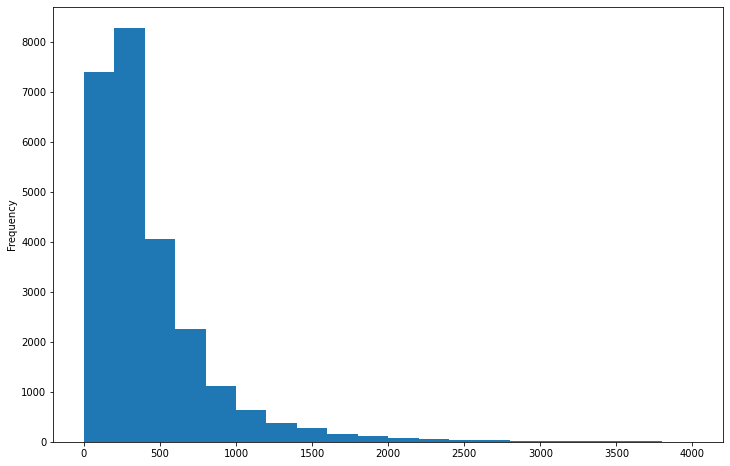

In [333]:
raw_data["Text"].str.len().plot.hist(bins=20, range=(0, 4000));

Dal grafico notiamo che la stragrande maggioranza delle recensioni è composta da [0 < x < 500] caratteri, ma ce ne sono alcune lunghe diverse migliaia.

Vediamo più nel dettaglio la distribuzione dei valori.

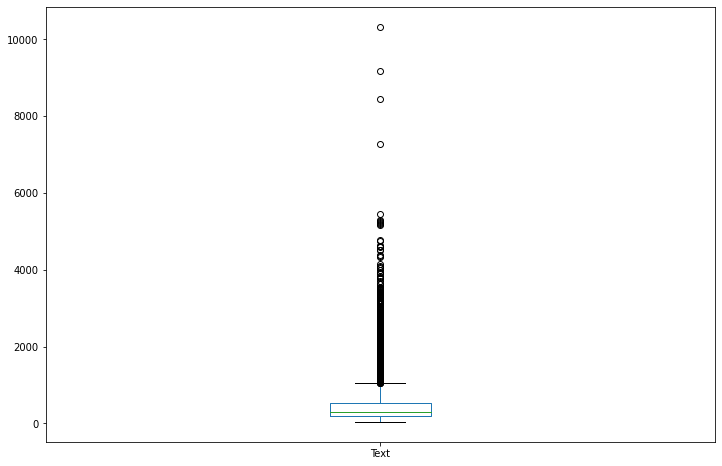

In [77]:
raw_data["Text"].str.len().plot.box();

In questo grafico sono più evidenti i valori "estremi", gli outliers: alcune recensioni sono lunghe più di 10000 caratteri! 

Vediamo qual'è la distribuzione di "stelle", nelle recensioni degli utenti

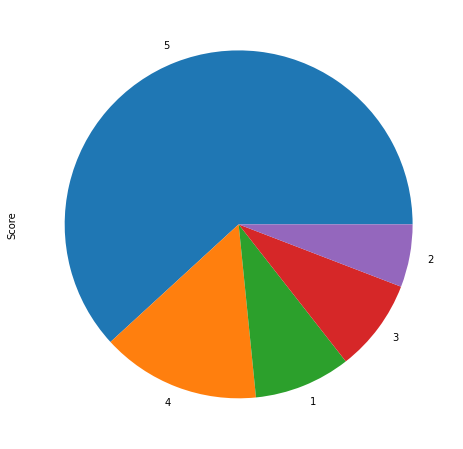

In [78]:
raw_data["Score"].value_counts().plot.pie();

La maggioranza delle recensioni hanno 5 stelle. Dato che vogliamo addestrare un modello che determini la polarità di una recensione, questo sbilanciamento potrebbe creare difficoltà. Successivamente dovremo risolvere questo problema.

La tabella che segue conferma le distribuzioni già viste nel grafico.

In [41]:
raw_data["Score"].describe()

count    25000.000000
mean         4.146320
std          1.312867
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Score, dtype: float64

Leggiamo alcune recensioni.

In [471]:
pd.set_option('display.max_colwidth', 150)
raw_data[["Score", "Text"]].head()

Score  \
Id          
1       5   
2       1   
3       4   
4       2   
5       5   

                                                                                                                                                     Text  
Id                                                                                                                                                         
1   I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew t...  
2   Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor i...  
3   This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut...  
4   If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (...  
5            Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taffy lover, this is a deal.

Leggendo qualche recensione notiamo che più lo score è alto, più il testo tende a contenere parole "positive", e viceversa. Ci sono eccezioni, come in caso di negazioni di parole (not ...). Questo è un problema che dobbiamo tenere a mente per dopo (ad esempio potremmo dover considerare termini composti da più parole, cioè n-grams più lunghi). 

Vediamo quante sono le recensioni neutrali (score 3)

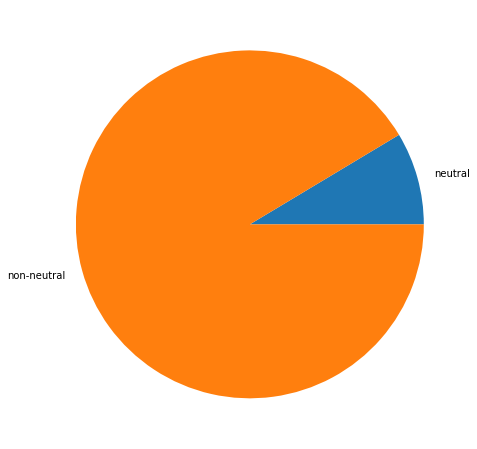

In [79]:
plt.pie([raw_data[raw_data["Score"] == 3]["Score"].count(), raw_data[raw_data["Score"] != 3]["Score"].count()], labels=["neutral", "non-neutral"]);

Le neutrali sono solo un 12% circa. Perciò, per semplificare le classi, possiamo non considerare le recensioni neutrali (score 3), senza ridurre troppo il nostro dataset.

In questo modo possiamo dividere nettamente le recensioni in positive e negative. Etichettiamo quindi con true le recensioni positive (> 3), e con false le negative (< 3), in modo da poterle rappresentare come valori booleani.

Selezioniamo soltanto le colonne che andremo ad utilizzare: ci servono solo il testo completo e il suo punteggio. Formiamo quindi un nuovo dataframe ridotto.

In [42]:
no_neutral = raw_data[raw_data['Score'] != 3]
data = pd.DataFrame({
    "Sentiment" : (no_neutral["Score"].apply(lambda score : True if score > 3 else False)).astype(bool),
    "Text" : (no_neutral["Text"])})
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22849 entries, 1 to 25000
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  22849 non-null  bool  
 1   Text       22849 non-null  string
dtypes: bool(1), string(1)
memory usage: 10.8 MB


Rimuovendo quelle neutrali, ci rimangono circa 23000 recensioni. Vediamo che aspetto ha la testa del dataframe.

In [472]:
data.head(10)

Sentiment  \
Id              
1        True   
2       False   
3        True   
4       False   
5        True   
6        True   
7        True   
8        True   
9        True   
10       True   

                                                                                                                                                     Text  
Id                                                                                                                                                         
1   I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew t...  
2   Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor i...  
3   This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut...  
4   If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (...  
5            Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taffy lover, this is a deal.  
6   I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, pep...  
7   This saltwater taffy had great flavors and was very soft and chewy.  Each candy was individually wrapped well.  None of the candies were stuck tog...  
8            This taffy is so good.  It is very soft and chewy.  The flavors are amazing.  I would definitely recommend you buying it.  Very satisfying!!  
9                     Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too  
10              This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Come in seguente grafico conferma, è probabile che dovremo usare tecniche di oversampling (come SMOTE) o undersampling (come RandomUnderSampler) per cercare di sopperire allo sbilanciamento di classi.

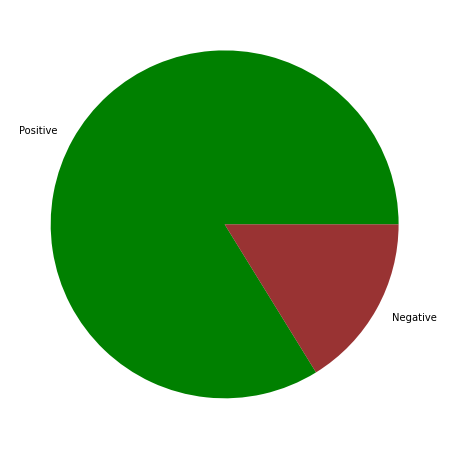

In [80]:
plt.pie(data["Sentiment"].value_counts(), labels=["Positive", "Negative"], colors=["green", (0.5, 0, 0, 0.8)]);

Il nostro dataset è ora pronto per essere utilizzato.
Abbiamo già stabilito di voler predire la polarità delle recensioni in funzione del loro testo (cioè Sentiment in funzione di Text), perciò marchiamo Text come la nostra X (variabile indipendente) e Sentiment come y (variabile dipendente).

In [59]:
X = data["Text"].astype(str)
y = data['Sentiment']

Dividiamo i nostri dati in due sottoinsiemi, usando il metodo Holdout con proporzioni 70-30, rispettivamente per testing e validation.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42
)

Ora dobbiamo pensare a quali modelli utilizzare per effettuare le nostre predizioni.

## Perceptron con Count Vectorizer

Così posto, il problema che dobbiamo affrontare è di classificazione: dobbiamo determinare se ogni istanza di Text (ogni testo di recensione) appartiene alla classe True (recensione positiva) oppure False (recensione negativa).

Utilizzare un perceptron come classificatore sarebbe un buon punto di partenza. Ma la nostra X è una serie di stringhe: non possiamo utilizzarla direttamente con il nostro modello. Dobbiamo quindi trovare un diverso modo di descrivere questi dati, per poterli rappresentare numericamente.

Creiamo perciò un Vector Space Model, considerando lo spazio vettoriale ottenuto rappresentando ogni testo di recensione con un vettore che associ ad ogni parola il suo numero di occorrenze in esso.

Questo spazio vettoriale sarà quindi una matrice documenti-termini, in cui ogni riga costituisce il vettore ricavato dal testo della recensione.

Per effettuare questa trasformazione, utilizziamo il filtro CountVectorizer di ScikitLearn.

In [176]:
model_perc = Pipeline([
    ("vectorizer", CountVectorizer(strip_accents="ascii", stop_words=nltk.corpus.stopwords.words("english"), max_features=10000)),
    ("classifier", Perceptron(n_jobs=-1, class_weight="balanced"))
])

Dato che dobbiamo passare al perceptron i dati già trasformati dal CountVectorizer, per comodità creiamo una Pipeline. Specifichiamo inoltre un corpus di stopwords più completo di quello di default, che il vectorizer userà per filtrare le parole da non includere, in quanto non aggiungono significato alla frase. 

Cerchiamo di bilanciare i pesi delle classi nella classificazione con class_weight="balanced".

Per limitare i tempi di calcolo, settiamo un numero massimo di features da utilizzare.

In [177]:
grid = {
    "vectorizer__min_df" : [3, 5, 10],
    "vectorizer__ngram_range" : [(1, 1), (1, 2), (1,3)],
    "classifier__penalty": ["l1", "l2"],
    "classifier__alpha": np.logspace(-5, -3, 3),
}

cv = StratifiedKFold(3, shuffle=True, random_state=42)

gs_perc = GridSearchCV(model_perc, grid, cv=cv, n_jobs=-1)

Prepariamo ora una gridsearch per ottimizzare alcuni importanti parametri. Per la validazione, usiamo una stratifiedKFold piuttosto che una Kfold, perchè nella fase esplorativa abbiamo osservato che ci troviamo di fronte ad un problema di classificazione con classi sbilanciate, e anche se questo non risolverà il problema, StratifiedKFold mantiene le proporzioni tra classi nei vari Fold, cosa che ci aiuterà a far fronte allo sbilanciamento nella fase di valutazione dei modelli.

Diamo il via alla gridsearch per cercare la combinazione ottimale dei parametri testati.

In [178]:
gs_perc.fit(X_train, y_train)
gs_perc.score(X_val, y_val)

0.8989103321517657

Abbiamo usato il metodo score per calcolare il coefficiente di determinazione R^2. Questo coefficiente indica la proporzione tra variabilità dei dati e correttezza del modello.

Il suo range di possibili valori va da 0 a 1, dove:

0 - indica che non c'è correlazione tra dati e modello (come può succedere in un modello casuale, ad esempio in un modello addestrato con una variabile indipendente che in realtà non ha correlazione con quella considerata dipendente)

1 - indica che il modello descrive perfettamente i dati.

Avendo ottenuto uno score di circa 0.9, i primi risultati sono incoraggianti. Vediamo nel dettaglio quali sono le combinazioni di parametri ottimali tra quelle che abbiamo testato

In [183]:
pd.DataFrame(gs_perc.cv_results_).sort_values("rank_test_score").head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4       7.028752      0.199474         1.724133        0.147281   
2      12.006607      0.529610         2.140416        0.259703   
5      11.456174      0.351759         1.931024        0.142208   
8      13.129084      0.203356         2.121599        0.272592   
1       6.234451      0.335846         1.562701        0.055763   

  param_classifier__alpha param_classifier__penalty param_vectorizer__min_df  \
4                 0.00001                        l1                        5   
2                 0.00001                        l1                        3   
5                 0.00001                        l1                        5   
8                 0.00001                        l1                       10   
1                 0.00001                        l1                        3   

  param_vectorizer__ngram_range  \
4                        (1, 2)   
2                        (1, 3)   
5                        (1, 3)   
8                        (1, 3)   
1                        (1, 2)   

                                              params  split0_test_score  \
4  {'classifier__alpha': 1e-05, 'classifier__pena...           0.883813   
2  {'classifier__alpha': 1e-05, 'classifier__pena...           0.885979   
5  {'classifier__alpha': 1e-05, 'classifier__pena...           0.891690   
8  {'classifier__alpha': 1e-05, 'classifier__pena...           0.885585   
1  {'classifier__alpha': 1e-05, 'classifier__pena...           0.888145   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
4           0.881426           0.896199         0.887146        0.006475   
2           0.884578           0.890093         0.886883        0.002341   
5           0.875517           0.892456         0.886554        0.007811   
8           0.881623           0.886547         0.884585        0.002131   
1           0.873547           0.880638         0.880777        0.005960   

   rank_test_score  
4                1  
2                2  
5                3  
8                4  
1                5

In [184]:
gs_perc.best_params_

{'classifier__alpha': 1e-05,
 'classifier__penalty': 'l1',
 'vectorizer__min_df': 5,
 'vectorizer__ngram_range': (1, 2)}

Gli iperparametri ottimali tra quelli testati sono:
- alpha = 1e-05  (peso della regolarizzazione)
- penalty = l1 (regol. lasso)
- min_df = 5 (considera solo termini che compaiono in >=5 documenti)
- ngram_range = (1,2) (considera monogrammi e bigrammi)

Avendo trovato i migliori parametri, assegnamoli al nostro modello.

Addestriamo quindi il modello sul set di training e salviamo in una variabile le predizioni ottenute sul set di validazione.

In [185]:
model_perc = gs_perc.best_estimator_

model_perc.fit(X_train,y_train)
model_perc_predictions = model_perc.predict(X_val)

Salviamo su disco il modello ottenuto

In [186]:
dump(model_perc, 'model_perc.joblib') 

['model_perc.joblib']

Per capire meglio quali features sono state considerate, e quale è il loro peso nella classificazione, definiamo una funzione che mostri le n feature più rilevanti (in positivo e in negativo) insieme al loro peso.

In [439]:
def most_impactful_features(classifier, vectorizer, num):
  weights = pd.Series(classifier.coef_[0], index=vectorizer.get_feature_names()).sort_values()
  pos = weights.tail(num).sort_values(ascending=False)
  neg = weights.head(num)
  return pd.DataFrame([pos.index, pos.values, neg.index, neg.values], index=["Features Positive", "Peso", "Features Negative", "Peso"]).T

Utilizziamo la funzione definita sopra per vedere le 16 features più rilevanti.

In [442]:
most_impactful_features(model_perc["classifier"], model_perc["vectorizer"], 16)

Features Positive       Peso Features Negative       Peso
0                lol  54.205815     disappointing -61.370307
1              yummy  48.413569          fructose  -60.16138
2            pleased  47.163177              yuck -58.982701
3             unlike  46.469429              blah -58.091462
4        even better  45.926132    disappointment -57.720685
5             hooked  45.578618          terrible -52.730856
6          excellent  44.914114             stool -52.608933
7             supply  44.051745         two stars -52.538989
8            perfect  40.609075              died  -51.74486
9              spicy  39.928085             worst -51.314518
10            colors  39.703174         never buy -47.065109
11              adds  39.440518            afraid -44.829224
12           awesome  39.245981            dumped -44.692487
13              mild  38.898967             shame -44.676643
14        reasonable  38.596999            google -43.915752
15            smooth  38.566947          horrible -43.853856

Come ci aspettavamo, a termini positivi corrispondono recensioni positive e viceversa.

Definiamo ora una funzione che ci permetta di vedere graficamente quali sono le distribuzioni dei coefficienti (pesi).

In [382]:
def plot_coef_distribution(classifier):
  plt.subplot(1, 2, 1)
  plt.boxplot(classifier.coef_[0]),
  plt.subplot(1, 2, 2)
  plt.hist(classifier.coef_[0]);

Chiamiamo la funzione definita sopra.

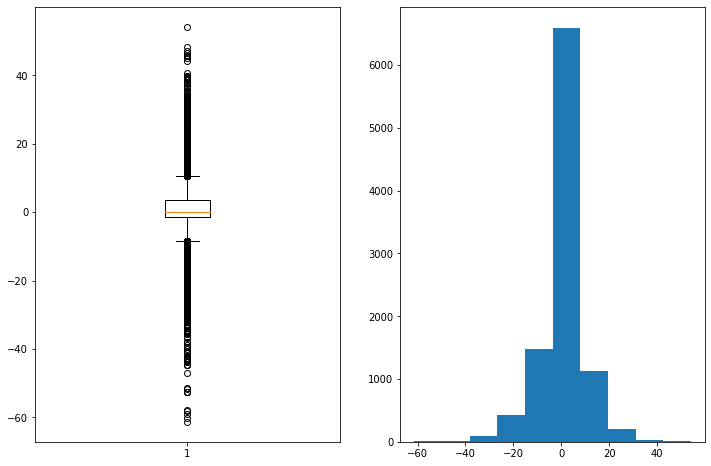

In [383]:
plot_coef_distribution(model_perc["classifier"])

Vediamo che la maggior parte delle features ha un peso relativamente basso (vicino a 0), mentre poche features (qualche decina, a giudicare dalla tabella che abbiamo visto prima) hanno peso tra 40 e 60: sono i termini "decisivi".

Ora possiamo vedere più nel dettaglio quanto il modello sia effettivamente accurato, in particolare ci interessa sapere quanto sia affidabile la predizione per ogni tipo di classe.

Visualizziamo alcuni indici:

- Precision - indica la capacità del modello di non classificare come positivo un campione negativo;

- Recall - indica la capacità del modello di individuare tutti i campioni positivi;

- F1-Score - Media ponderata tra Precision e Recall.

In [187]:
print(classification_report(y_val, model_perc_predictions))

              precision    recall  f1-score   support

       False       0.68      0.70      0.69      1220
        True       0.94      0.94      0.94      6397

    accuracy                           0.90      7617
   macro avg       0.81      0.82      0.81      7617
weighted avg       0.90      0.90      0.90      7617



Questo report evidenzia un problema: il modello riesce a classificare in maniera abbastanza affidabile le recensioni positive, ma ha problemi con quelle negative. La colonna support ci conferma che le classi sono sbilanciate: come avevamo notato durante la fase esplorativa, abbiamo molti meno campioni di recensioni negative rispetto alle positive.

Diamo un'occhiata alla matrice di confusione.

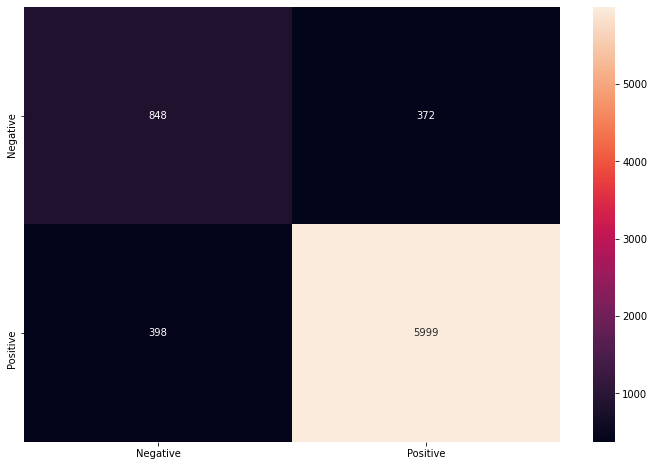

In [334]:
heatmap(confusion_matrix(y_val, model_perc_predictions), annot=True, cmap="rocket", fmt='d', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"]);

Dalla matrice ritroviamo ciò che già avevamo dedotto dalla tabella precedente. Recuperiamo un grafico dall'analisi esplorativa

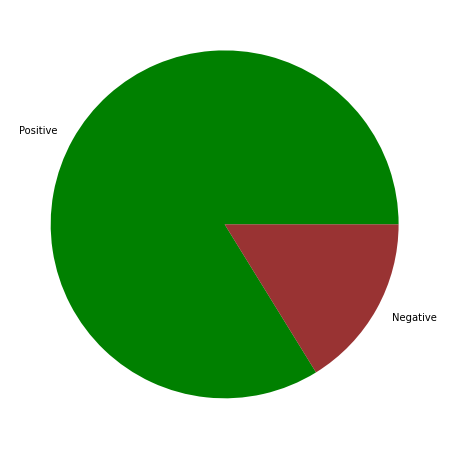

In [335]:
plt.pie(data["Sentiment"].value_counts(), labels=["Positive", "Negative"], colors=["green", (0.5, 0, 0, 0.8)]);

Le recensioni negative sono solo circa il 16%. Cis sono quindi segni che lo sbilanciamento tra classi sta probabilmente creando problemi nella nostra classificazione.

Se vogliamo migliorare l'accuratezza del modello, bilanciare le classi può essere un buon punto di partenza.
Per farlo usiamo SMOTE dal pacchetto imbalanced learn, per creare campioni sintetici di recensioni negative partendo da quelli correnti (tramite oversampling).

## Perceptron con Count Vectorizer e SMOTE

Per evitare di avere dei campioni sintetici nel set di validation, facciamo oversampling solo sul set di training. Possiamo farlo direttamente nella Pipeline.

Potrebbe essere una buona idea ripetere la gridsearch per ottimizzare gli iperparametri, dato che ora che nel set di training ci sono nuovi campioni.

Per tagliare i tempi di calcolo, riutilizziamo comunque i parametri precedenti: riaddestriamo però il modello sui nuovi dati generati.

In [105]:
model_perc_bal = imblearn.pipeline.Pipeline([
    ("vectorizer", model_perc["vectorizer"]),
    ("balancer", SMOTE(random_state=42)),
    ("classifier", model_perc["classifier"])
])

Abbiamo usato una Pipeline del pacchetto imblearn, perchè quella di sklearn non supporta SMOTE al suo interno.

Addestriamo il modello, e valutiamone il coefficiente R^2

In [106]:
model_perc_bal.fit(X_train, y_train)
model_perc_bal_pred = model_perc_bal.predict(X_val)
model_perc_bal.score(X_val, y_val)

0.8832873834843115

Salviamo il modello su disco

In [190]:
dump(model_perc_bal, 'model_perc_bal.joblib') 

['model_perc_bal.joblib']

Utilizziamo la funzione che avevamo definito in precedenza, per vedere le features più rilevanti.

In [446]:
most_impactful_features(model_perc_bal["classifier"], model_perc_bal["vectorizer"], 16)

Features Positive      Peso Features Negative      Peso
0             colors  27.08588         two stars -36.07949
1              coats  27.08225              blah -34.07522
2               adds   27.0791    disappointment -29.07464
3             hooked  26.07694          diarrhea -26.07903
4        even better  26.07596     disappointing -26.07442
5          excellent  25.07438          sticking -25.07592
6              fiber  24.07497         never buy -25.07461
7         enjoy good  23.08731             worst  -25.0745
8       tastes great  23.07571             stool -24.09967
9             unlike  22.07514          fructose -23.08024
10             yummy  22.07462              died -23.07534
11           pleased  22.07448          brand br -21.07488
12           awesome  22.07438           returns -21.07474
13               max  21.10506          terrible -21.07456
14         br thanks  21.08283            dumped -20.07533
15          br price  21.08109       undrinkable -20.07523

Vediamo che il bilanciamento ha cambiato drasticamente le features e il loro peso. Vediamo i grafici.

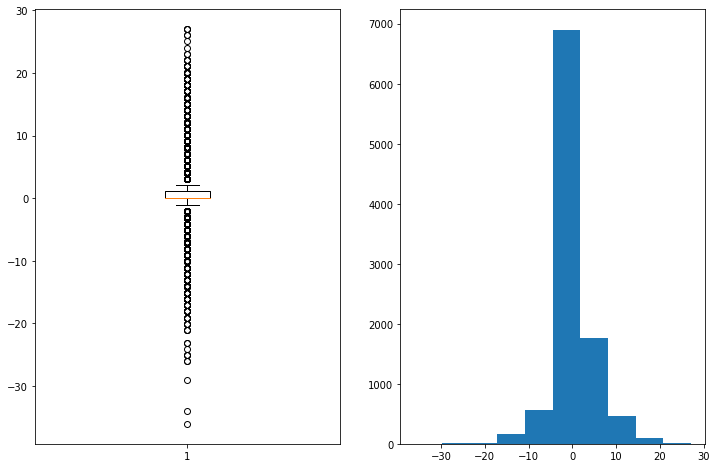

In [384]:
plot_coef_distribution(model_perc_bal["classifier"])

Vediamo come la tecnica di oversampling che abbiamo usato (SMOTE) abbia reso la distribuzione dei pesi più regolare. Anche la differenza massima tra i pesi è diminuita (le feature più influenti hanno peso di circa 30, prima circa 60).

Vediamo le statistiche del modello.

In [191]:
print(classification_report(y_val, model_perc_bal_pred))

              precision    recall  f1-score   support

       False       0.62      0.71      0.66      1220
        True       0.94      0.92      0.93      6397

    accuracy                           0.88      7617
   macro avg       0.78      0.81      0.80      7617
weighted avg       0.89      0.88      0.89      7617



Questa tecnica di oversampling non ci ha aiutato: in generale il modello è peggiorato lievemente.

Vediamo la matrice di confusione.

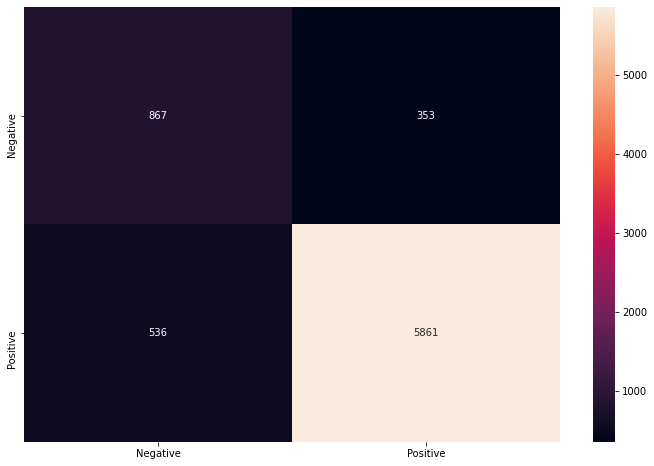

In [108]:
heatmap(confusion_matrix(y_val, model_perc_bal_pred), annot=True, cmap="rocket", fmt='d', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"]);

C'è altro che possiamo fare per migliorare i risultati. Ad esempio, possiamo provare ad usare un classificatore più avanzato rispetto a un semplice Perceptron: proviamo con la Regressione Logistica.

## Regressione Logistica con Count Vectorizer

Costruiamo una Pipeline simile a quella iniziale, ma usando la Regressione Logistica come classificatore

In [217]:
model_lr_cv = Pipeline([
    ("vectorizer", CountVectorizer(strip_accents="ascii", stop_words=nltk.corpus.stopwords.words("english"), max_features=10000)),
    ("classifier", LogisticRegression(solver="saga", class_weight="balanced", n_jobs=-1))
])

Prepariamo una gridsearch, usando uno StratifiedKFold per la valutazione (stessa ragione di prima)

In [218]:
grid = {
    'classifier__C' : [1, 3, 5],
    'classifier__penalty': ['l2', 'l1'],
    "vectorizer__min_df" : [3, 5, 10],
    "vectorizer__ngram_range" : [(1, 2), (1,3)]
}

cv = StratifiedKFold(3, shuffle=True, random_state=42)

gs_cv = GridSearchCV(model_lr_cv, grid, cv=cv, n_jobs=-1)

Eseguiamo la gridsearch ed esaminiamo il coefficiente R^2

In [219]:
gs_cv.fit(X_train, y_train)
gs_cv.score(X_val, y_val)

0.8869633714060654

Lo score è leggermente più basso di quello ottenuto dal Perceptron. Vediamo quali combinazioni di parametri sono migliori.

In [220]:
pd.DataFrame(gs_cv.cv_results_).sort_values("rank_test_score").head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       13.252698      0.246926         2.437704        0.086288   
13      18.039838      0.335469         2.758701        0.161972   
1       18.165355      1.340109         2.308179        0.179875   
14      12.419185      0.228184         2.182544        0.039894   
25      11.613652      0.104135         1.618448        0.056589   

   param_classifier__C param_classifier__penalty param_vectorizer__min_df  \
0                    1                        l2                        3   
13                   3                        l2                        3   
1                    1                        l2                        3   
14                   3                        l2                        5   
25                   5                        l2                        3   

   param_vectorizer__ngram_range  \
0                         (1, 2)   
13                        (1, 3)   
1                         (1, 3)   
14                        (1, 2)   
25                        (1, 3)   

                                               params  split0_test_score  \
0   {'classifier__C': 1, 'classifier__penalty': 'l...           0.889327   
13  {'classifier__C': 3, 'classifier__penalty': 'l...           0.889130   
1   {'classifier__C': 1, 'classifier__penalty': 'l...           0.889130   
14  {'classifier__C': 3, 'classifier__penalty': 'l...           0.889327   
25  {'classifier__C': 5, 'classifier__penalty': 'l...           0.888736   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.882608           0.876699         0.882878        0.005159   
13           0.882805           0.876502         0.882812        0.005155   
1            0.882608           0.876305         0.882681        0.005236   
14           0.882017           0.876699         0.882681        0.005177   
25           0.882411           0.876699         0.882615        0.004916   

    rank_test_score  
0                 1  
13                2  
1                 3  
14                4  
25                5

In [221]:
gs_cv.best_params_

{'classifier__C': 1,
 'classifier__penalty': 'l2',
 'vectorizer__min_df': 3,
 'vectorizer__ngram_range': (1, 2)}

- C = 1 (inverso del peso della regolarizzazione: valore piccolo -> peso maggiore)
- penalty = l2 (regolariz. ridge)
- min_df = 3 (considera termini presenti in almeno 3 documenti)
- ngram_range = (1,2) (considera monogrammi e bigrammi) 

Assegnamo i migliori parametri al nostro modello.

In [222]:
model_lr_cv = gs_cv.best_estimator_

Addestriamolo e salviamo le predizioni

In [224]:
model_lr_cv.fit(X_train,y_train)
model_lr_cv_predictions = model_lr_cv.predict(X_val)

Salviamolo su disco

In [223]:
dump(model_lr_cv, 'model_lr_cv.joblib') 

['model_lr_cv.joblib']

Vediamo le features più rilevanti

In [443]:
most_impactful_features(model_lr_cv["classifier"], model_lr_cv["vectorizer"], 16)

Features Positive      Peso Features Negative      Peso
0               nice  1.151238      disappointed -1.184277
1              loves  1.090686          terrible  -0.92178
2          delicious  1.072303                ok -0.848561
3          excellent   1.06839              away -0.847021
4            perfect  1.063414              weak -0.836622
5           favorite  0.952111          horrible -0.809377
6              great   0.91483             money -0.775807
7               best  0.883559             waste -0.742635
8          wonderful  0.776034     unfortunately -0.724226
9               love  0.743336           thought -0.706045
10            highly  0.717291             worst -0.700799
11            smooth  0.713539               bad -0.696556
12           amazing  0.639011     disappointing  -0.65495
13             tasty  0.624254              idea -0.643876
14             yummy  0.620573            return -0.639371
15            stores  0.608004             stick -0.629497

Grafichiamone la distribuzione

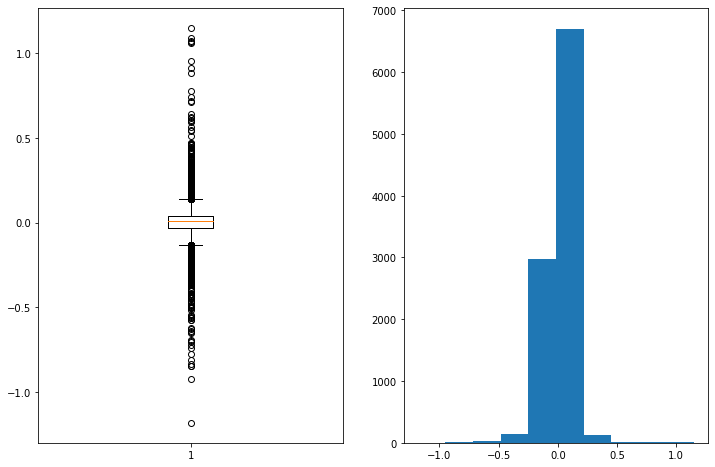

In [385]:
plot_coef_distribution(model_lr_cv["classifier"])

In questo modello, i pesi hanno valori più "stabili", perlopiù -1 < x < 1. Questo potrebbe dipendere anche dal peso della regolarizzazione utilizzato (nel ridurre il valore dei coefficienti).

Restano comunque pochi gli outliers con valori elevati (vicino ad 1), la maggior parte ha valore prossimo a 0.

Ora vediamo più nel dettaglio le performance che abbiamo ottenuto

In [225]:
print(classification_report(y_val, model_lr_cv_predictions))

              precision    recall  f1-score   support

       False       0.61      0.83      0.70      1220
        True       0.97      0.90      0.93      6397

    accuracy                           0.89      7617
   macro avg       0.79      0.86      0.82      7617
weighted avg       0.91      0.89      0.89      7617



In generale, le statistiche sono leggermente migliori dei modelli precedenti, ma molto di poco.

Vediamo la matrice di confusione.

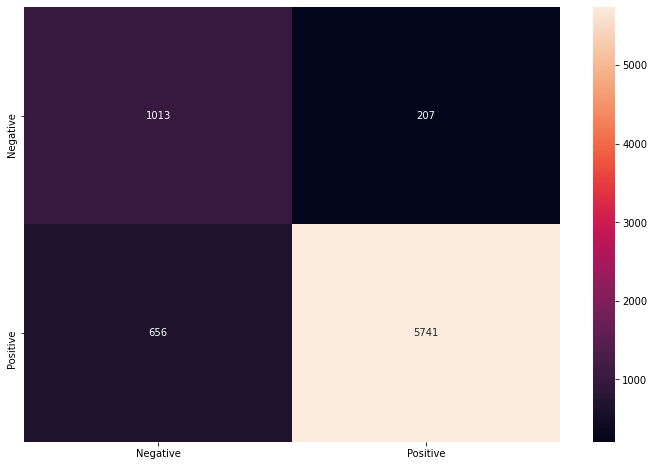

In [355]:
heatmap(confusion_matrix(y_val, model_lr_cv_predictions), annot=True, cmap="rocket", fmt='d', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"]);

Dato che i risultati non sono cambiati di molto, proviamo ad usare SMOTE anche con questo modello.

## Regressione Logistica con Count Vectorizer e SMOTE

Recuperiamo la Pipeline precedente, ma aggiungiamo SMOTE come balancer.

In [227]:
model_lr_cv_bal = Pipeline([
    ("vectorizer", model_lr_cv["vectorizer"]),
    ("balancer", SMOTE(random_state=42)),
    ("classifier", model_lr_cv["classifier"])
])

Addestriamo il modello, salviamo le predizioni e calcoliamo lo score

In [228]:
model_lr_cv_bal.fit(X_train,y_train)
model_lr_cv_bal_pred = model_lr_cv_bal.predict(X_val)
model_lr_cv_bal.score(X_val, y_val)

0.8824996717867927

Lo score è prossimo ai precedenti. 

Salviamo il modello su disco

In [229]:
dump(model_lr_cv_bal, 'model_lr_cv_bal.joblib') 

['model_lr_cv_bal.joblib']

Vediamo le features più rilevanti

In [444]:
most_impactful_features(model_lr_cv_bal["classifier"], model_lr_cv_bal["vectorizer"], 16)

Features Positive      Peso Features Negative      Peso
0              loves   1.60618      disappointed  -0.95062
1          delicious  1.504137              weak -0.811351
2               nice  1.437992              away -0.804172
3              great  1.386788          horrible -0.784058
4          excellent  1.361126             money -0.746228
5           favorite    1.3577             would -0.711548
6            perfect  1.300112          terrible -0.694392
7               love  1.231777             waste -0.647279
8               best  1.227239           plastic  -0.63173
9          wonderful  1.100042             worst -0.619412
10             tasty   0.99796               bad  -0.60425
11            smooth  0.983754                ok -0.568508
12             happy   0.82018             taste -0.563588
13             enjoy  0.794825           thought -0.536332
14            highly   0.79039             maybe -0.499693
15           amazing  0.785264             burnt -0.496671

I pesi sono leggermente diversi rispetto alla versione non bilanciata, ma rimangono sostanzialmente simili.

Vediamone la distribuzione

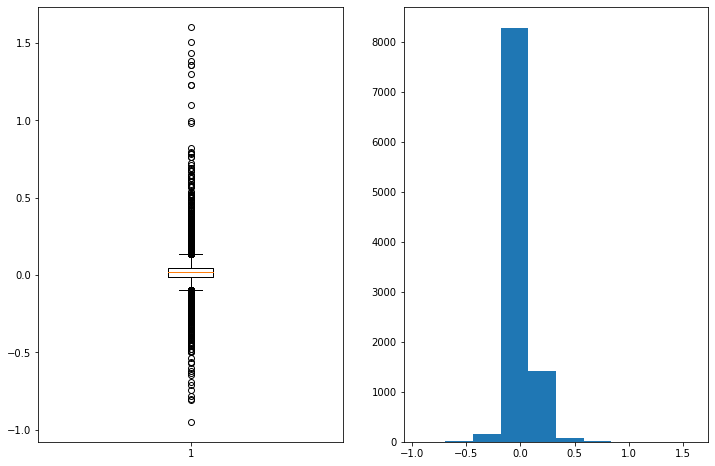

In [386]:
plot_coef_distribution(model_lr_cv_bal["classifier"])

Notiamo un maggior numero di outliers, tra le features positive. A parte questo, le distribuzioni rimangono simili.

Vediamo le metriche di accuratezza.

In [230]:
print(classification_report(y_val, model_lr_cv_bal_pred))

              precision    recall  f1-score   support

       False       0.62      0.68      0.65      1220
        True       0.94      0.92      0.93      6397

    accuracy                           0.88      7617
   macro avg       0.78      0.80      0.79      7617
weighted avg       0.89      0.88      0.88      7617



I risultati non sono migliorati con l'oversampling, infatti sono peggiorati lievemente.

Vediamo la matrice di confusione

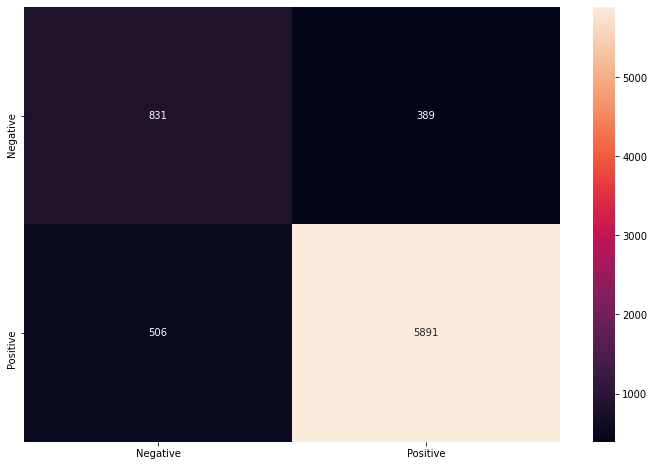

In [337]:
heatmap(confusion_matrix(y_val, model_lr_cv_bal_pred), annot=True, cmap="rocket", fmt='d', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"]);

La matrice conferma che il modello non è più preciso o affidabile di prima. Proviamo ad utilizzare un metodo diverso per processare il testo: per esempio, possiamo utilizzare un TfIdfVectorizer.


## Regressione Logistica con Tf-Idf Vectorizer

Tf-Idf sta per "term frequency-inverse document frequency". Ad ogni termine vengono assegnati due pesi:

- Tf - importanza locale di un termine in un documento. E' pari al suo numero di occorrenze (come in CountVectorizer)
- Idf - importanza globale di un termine, più è alta meno il termine è comune nell'insieme dei documenti (diamo più peso ai termini rari)

Una volta calcolati i due pesi, ciascun vettore è normalizzato in modo da avere norma euclidea pari a 1, per appianare differenze di pesi tra documenti di diversa lunghezza.

Questo è un metodo più avanzato rispetto al CountVectorizer: invece di contare solo il numero di occorrenze dei termini nei documenti, considera anche quanto i termini sono rari nell'insieme di tutti i documenti.

Costruiamo una pipeline come la precedente, ma senza SMOTE e usando un vectorizer tf-idf piuttosto che count.


In [232]:
model_tf = Pipeline([
    ("vectorizer", TfidfVectorizer(strip_accents="ascii", stop_words=nltk.corpus.stopwords.words("english"), max_features=10000)),
    ("classifier", LogisticRegression(solver="saga", class_weight ="balanced", n_jobs=-1))
])

Costruiamo una gridsearch come abbiamo fatto precedentemente, usando gli stessi parametri per la ricerca ma utilizzando un "filtro" Tf-Idf

In [233]:
grid = {
    'classifier__C' : [1, 3, 5, 10],
    'classifier__penalty': ['l2', 'l1'],
    "vectorizer__min_df" : [3, 5, 10],
    "vectorizer__ngram_range" : [(1, 2), (1,3)],
    "vectorizer__sublinear_tf" : [True, False]
}

cv = StratifiedKFold(3, shuffle=True, random_state=42)

gs_tf = GridSearchCV(model_tf, grid, cv=cv, n_jobs=-1)

Ricerchiamo i parametri e calcoliamo il coefficiente R^2

In [234]:
gs_tf.fit(X_train, y_train)
gs_tf.score(X_val, y_val)

0.912826572141263

Lo score è leggermente migliore rispetto a quello ottenuto con il CountVectorizer. Vediamo i parametri.

In [235]:
pd.DataFrame(gs_tf.cv_results_).sort_values("rank_test_score").head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
72       6.161267      0.110860         1.193066        0.011812   
54       9.773548      0.101431         1.553226        0.028754   
48       5.737993      0.131252         1.230229        0.033504   
76       6.295800      0.052073         1.221221        0.025597   
77       6.249700      0.072896         1.223305        0.023278   

   param_classifier__C param_classifier__penalty param_vectorizer__min_df  \
72                  10                        l2                        3   
54                   5                        l2                        5   
48                   5                        l2                        3   
76                  10                        l2                        5   
77                  10                        l2                        5   

   param_vectorizer__ngram_range param_vectorizer__sublinear_tf  \
72                        (1, 2)                           True   
54                        (1, 3)                           True   
48                        (1, 2)                           True   
76                        (1, 2)                           True   
77                        (1, 2)                          False   

                                               params  split0_test_score  \
72  {'classifier__C': 10, 'classifier__penalty': '...           0.907444   
54  {'classifier__C': 5, 'classifier__penalty': 'l...           0.907050   
48  {'classifier__C': 5, 'classifier__penalty': 'l...           0.907050   
76  {'classifier__C': 10, 'classifier__penalty': '...           0.906656   
77  {'classifier__C': 10, 'classifier__penalty': '...           0.905868   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
72           0.903289           0.903092         0.904609        0.002007   
54           0.902108           0.901911         0.903689        0.002378   
48           0.902108           0.901911         0.903689        0.002378   
76           0.901320           0.902305         0.903427        0.002319   
77           0.901517           0.902698         0.903361        0.001837   

    rank_test_score  
72                1  
54                2  
48                2  
76                4  
77                5

In [236]:
gs_tf.best_params_

{'classifier__C': 10,
 'classifier__penalty': 'l2',
 'vectorizer__min_df': 3,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__sublinear_tf': True}

- C = 10 (inverso del peso della regolarizzazione: valore piccolo -> peso maggiore)
- penalty = l2 (regolariz. ridge)
- min_df = 3 (considera termini presenti in almeno 3 documenti)
- ngram_range = (1,2) (considera monogrammi e bigrammi)
- sublinear_tf = True (la scala della term frequency (tf) ha peso (1 + e^tf) piuttosto che tf: non scala più linearmente) 

Assegnamo i migliori parametri al nostro modello.

In [237]:
model_lr_tf = gs_tf.best_estimator_

Addestriamolo e salviamo le predizioni

In [238]:
model_lr_tf.fit(X_train,y_train)
model_lr_tf_predictions = model_lr_tf.predict(X_val)

Salviamo il modello su disco

In [239]:
dump(model_lr_tf, 'model_lr_tf.joblib')

['model_lr_tf.joblib']

Analizziamo le features più rilevanti

In [445]:
most_impactful_features(model_lr_tf["classifier"], model_lr_tf["vectorizer"], 16)

Features Positive       Peso Features Negative       Peso
0              great  11.230729          terrible -10.177309
1               love   9.801316      disappointed  -9.138682
2               best   9.728407          horrible  -8.268923
3          delicious   9.563074             worst  -8.011169
4               nice   9.501827     disappointing  -8.010968
5          excellent   9.375516              yuck  -7.959536
6            perfect   9.164108                ok  -7.734683
7               good   8.936336    disappointment  -7.524315
8              loves   8.900924              weak  -7.305689
9           favorite   7.566246            return  -7.247226
10             yummy   7.243712         never buy  -7.197772
11           pleased    7.13828              died  -7.103247
12            smooth   6.880632     unfortunately  -6.633891
13         wonderful     6.4512             stick   -6.42075
14               lol   6.250452             threw  -6.314431
15            always   6.083621           neither  -6.247891

Vediamone la distribuzione

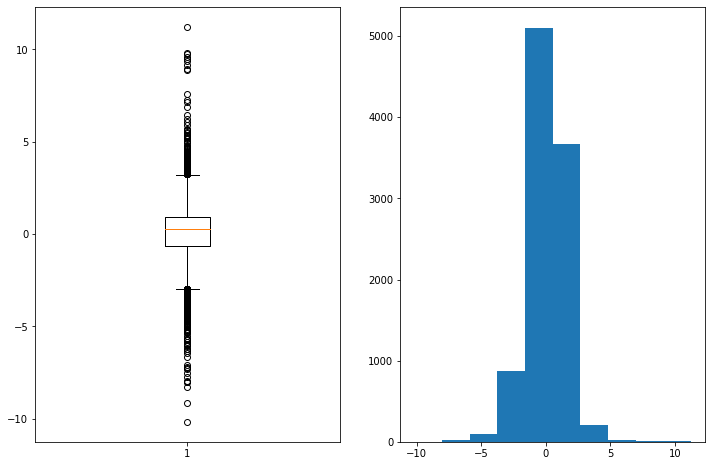

In [395]:
plot_coef_distribution(model_lr_tf["classifier"])

Notiamo che i coefficienti hanno valore più alto: in questo modello la regolarizzazione ha peso minore rispetto al precedente (C=10 vs 1). Questa potrebbe esserne la ragione.

Vediamo le metriche.

In [240]:
print(classification_report(y_val, model_lr_tf_predictions))

              precision    recall  f1-score   support

       False       0.70      0.80      0.74      1220
        True       0.96      0.93      0.95      6397

    accuracy                           0.91      7617
   macro avg       0.83      0.87      0.85      7617
weighted avg       0.92      0.91      0.91      7617



Il modello è più accurato rispetto ai precedenti. In particolare, ha score migliore nel riconoscere la classe False, che è quella che ci dà più problemi.

Vediamo la matrice di confusione.

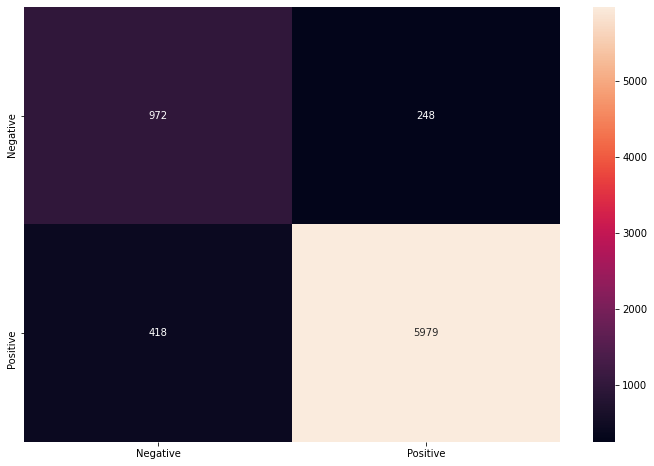

In [367]:
heatmap(confusion_matrix(y_val, model_lr_tf_predictions), annot=True, cmap="rocket", fmt='d', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"]);

Ora proviamo a fare oversampling sulla classe di minoranza, e analizziamo i risultati.

## Regressione Logistica con Tf-Idf Vectorizer e SMOTE

Costruiamo la solita pipeline, inserendo SMOTE all'interno. Come prima, utilizziamo gli stessi parametri che abbiamo usato nella versione senza oversampling.

In [242]:
model_lr_tf_bal = Pipeline([
    ("vectorizer", model_lr_tf["vectorizer"]),
    ("balancer", SMOTE(random_state=42)),
    ("classifier", model_lr_tf["classifier"])
])

Riaddestriamo il modello sui dati bilanciati, salviamo le predizioni, e calcoliamo il coefficiente di determinazione R^2

In [460]:
model_lr_tf_bal.fit(X_train,y_train)
model_lr_tf_bal_pred = model_lr_tf_bal.predict(X_val)
model_lr_tf_bal.score(X_val, y_val)

0.9163712747800972

Lo score è incoraggiante, ma dobbiamo vedere come il modello si comporta con ogni classe prima di poterlo giudicare.

Salviamolo su disco.

In [244]:
dump(model_lr_tf_bal, 'model_lr_tf_bal.joblib')

['model_lr_tf_bal.joblib']

Vediamo le features più rilevanti.

In [448]:
most_impactful_features(model_lr_tf_bal["classifier"], model_lr_tf_bal["vectorizer"], 16)

Features Positive       Peso Features Negative       Peso
0              great  12.788716          terrible -12.393883
1          delicious  11.218599      disappointed  -10.73819
2               best  11.043847             worst  -9.820411
3               nice  11.038363     disappointing  -9.288472
4               love  10.731579                ok  -9.277314
5          excellent  10.487456    disappointment  -9.259948
6            perfect  10.360988          horrible  -9.057558
7               good  10.153628              weak  -8.916373
8              loves   9.948812              yuck  -8.680479
9           favorite   8.634575         never buy  -8.470632
10             yummy   8.078044            return  -8.418379
11           pleased   7.913915              died  -7.796692
12            smooth   7.789286             stick  -7.757369
13               lol   7.392214     unfortunately  -7.748277
14         wonderful   7.082227              even  -7.530562
15           awesome   7.062424             threw  -7.345722

Vediamo le distribuzioni.

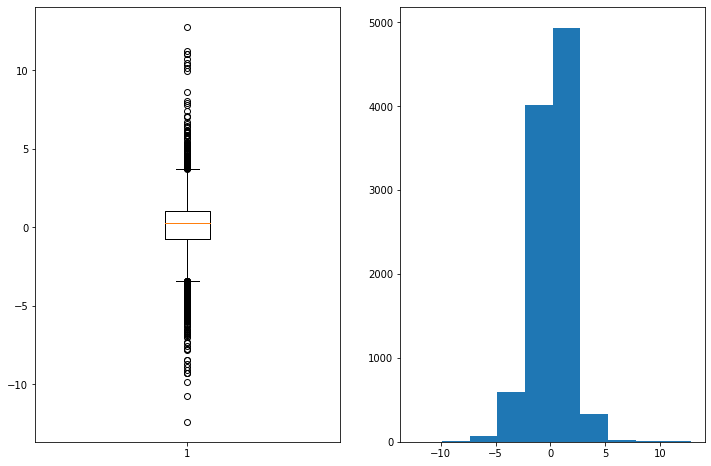

In [392]:
plot_coef_distribution(model_lr_tf_bal["classifier"])

In questo modello, abbiamo usato gli stessi parametri del precedente, e possiamo osservare che i coefficienti hanno lo stesso range di valori: questo dà credito all'ipotesi che sia maggiormente il tipo e il peso della regolarizzazione a determinare il range di valori dei coefficienti (In fondo lo scopo della regolarizzazione è proprio quello!)

Vediamo le metriche del modello

In [245]:
print(classification_report(y_val, model_lr_tf_bal_pred))

              precision    recall  f1-score   support

       False       0.73      0.77      0.75      1220
        True       0.96      0.94      0.95      6397

    accuracy                           0.92      7617
   macro avg       0.84      0.86      0.85      7617
weighted avg       0.92      0.92      0.92      7617



Tramite oversampling, abbiamo migliorato leggermente lo score, la media macro è ora 0.85

Vediamo la matrice di confusione

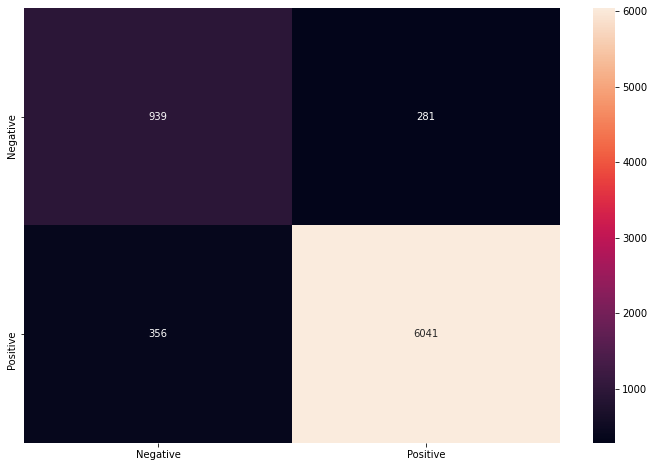

In [366]:
heatmap(confusion_matrix(y_val, model_lr_tf_bal_pred), annot=True, cmap="rocket", fmt='d', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"]);

A questo punto, abbiamo raggiunto risultati abbastanza soddisfacenti. Ma possiamo fare un'ultima prova: al posto di usare il tokenizer di default fornito dal Tf-Idf Vectorizer, definiamo una nostra funzione che applichi la tecnica dello Stemming.

## Regressione Logistica con Tf-Idf Vectorizer, Smote, e Stemming

Partiamo dall'ultimo modello (che si era rivelato il migliore tra quelli testati)

In [169]:
model_lr_tf_bal_stem = model_lr_tf_bal

Come algoritmo di stemming, utilizziamo PorterStemmer dal pacchetto nltk. Il nostro scopo è estrarre la radice morfologica dei termini, ed utilizzare questa per l'addestramento. Questo potrebbe sia portare ad una diminuzione del numero delle features, che ad un aumento dell'accuratezza.

In [372]:
ps = nltk.stem.PorterStemmer()

Sostituiamo al tokenizer di default una funzione che applichi lo stemming ad ogni token estratto dal testo originale.

In [373]:
model_lr_tf_bal_stem["vectorizer"].tokenizer = lambda text: [ps.stem(token) for token in nltk.word_tokenize(text)]

Addestriamo il modello così ottenuto e salviamone le predizioni.

In [374]:
model_lr_tf_bal_stem.fit(X_train, y_train);
model_lr_tf_bal_stem_pred = model_lr_tf_bal_stem.predict(X_val)

Vediamo le features più importanti

In [449]:
most_impactful_features(model_lr_tf_bal_stem["classifier"], model_lr_tf_bal_stem["vectorizer"], 16)

Features Positive       Peso Features Negative       Peso
0              great  11.984396           terribl -11.906776
1               love  11.197924   veri disappoint -10.507405
2               best  11.126508        disappoint -10.231127
3               nice  10.874007             worst  -9.972389
4              excel  10.472758             vomit  -9.762227
5            favorit  10.339382            return  -9.435475
6               good   9.988892                ok  -9.248416
7            perfect   9.891714              weak  -9.062917
8             delici   9.400379        veri littl  -9.036502
9             smooth   7.683057         never buy   -9.01348
10                 !    7.64201           horribl   -8.71305
11        tast great   7.568415           disgust  -8.032695
12          love thi   6.909338                aw  -8.031581
13         thi great   6.850817           n't buy  -7.693622
14               lol   6.819015             shame  -7.395154
15            awesom    6.69095            yuck !  -7.251854

Si può notare l'effetto dello stemming sui termini.

Vediamo la distribuzione dei pesi

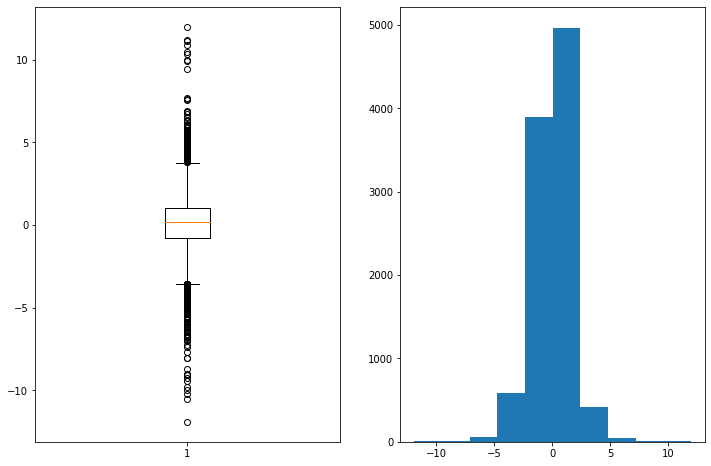

In [396]:
plot_coef_distribution(model_lr_tf_bal_stem["classifier"])

Come al solito, abbiamo qualche outlier "decisivo" e la maggior parte dei pesi prossima allo zero.

Vediamo le metriche

In [375]:
print(classification_report(y_val, model_lr_tf_bal_stem_pred))

              precision    recall  f1-score   support

       False       0.73      0.79      0.76      1220
        True       0.96      0.94      0.95      6397

    accuracy                           0.92      7617
   macro avg       0.85      0.87      0.86      7617
weighted avg       0.92      0.92      0.92      7617



Lo score è molto simile ai precedenti, ma leggermente migliore.

Vediamo la matrice di confusione.

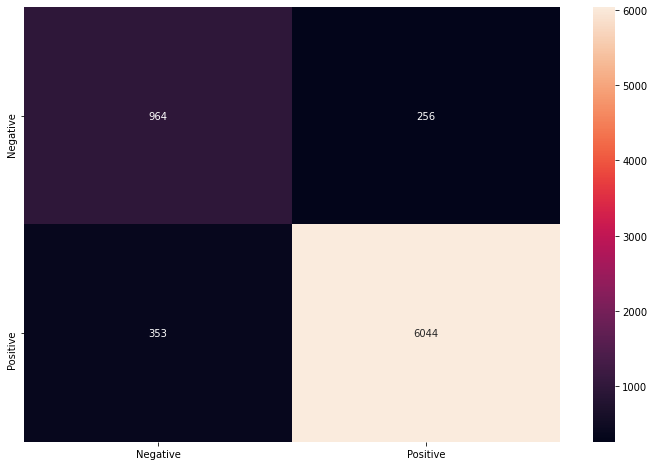

In [376]:
heatmap(confusion_matrix(y_val, model_lr_tf_bal_stem_pred), annot=True, cmap="rocket", fmt='d', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"]);

Con una media macro dello f1-score di 0.86, abbiamo raggiunto un'accuratezza soddisfacente.

Mettiamo ora a confronto tutti i modelli testati.

## Conclusioni

Definiamo una funzione che calcoli precision, recall, ed f-1 dei nostri modelli, e li restituisca in un set.

In [164]:
def evaluate(model, X, y):
  return {"precision" : precision_score(y, model.predict(X), pos_label=1, average="macro"),
          "recall": recall_score(y, model.predict(X), average="macro"), 
          "f1-score": f1_score(y, model.predict(X), average="macro")}

Creiamo ora un dataframe che raccolga le informazioni ottenute, specificandone gli indici

In [250]:
index = ["Perceptron, Count Vectorizer", "Perceptron, Count Vectorizer, SMOTE", "Regressione Logistica, Count Vectorizer", "Regressione Logistica, Count Vectorizer, SMOTE",
         "Regressione Logistica, Tf-Idf Vectorizer", "Regressione Logistica, Tf-Idf Vectorizer, SMOTE", "Regressione Logistica, Tf-Idf Vectorizer, SMOTE, Stemming"]

pd.DataFrame([evaluate(model_perc, X_val, y_val),
              evaluate(model_perc_bal, X_val, y_val),
              evaluate(model_lr_cv, X_val, y_val),
              evaluate(model_lr_cv_bal, X_val, y_val),
              evaluate(model_lr_tf, X_val, y_val),
              evaluate(model_lr_tf_bal, X_val, y_val),
              evaluate(model_lr_tf_bal_stem, X_val, y_val)],
              index=index).sort_values(by="f1-score")

precision    recall  \
Regressione Logistica, Count Vectorizer, SMOTE       0.779799  0.801024   
Perceptron, Count Vectorizer, SMOTE                  0.780577  0.813433   
Perceptron, Count Vectorizer                         0.811094  0.816433   
Regressione Logistica, Count Vectorizer              0.786472  0.864710   
Regressione Logistica, Tf-Idf Vectorizer             0.829727  0.865689   
Regressione Logistica, Tf-Idf Vectorizer, SMOTE      0.840324  0.857011   
Regressione Logistica, Tf-Idf Vectorizer, SMOTE...   0.845666  0.867491   

                                                    f1-score  
Regressione Logistica, Count Vectorizer, SMOTE      0.789690  
Perceptron, Count Vectorizer, SMOTE                 0.795291  
Perceptron, Count Vectorizer                        0.813723  
Regressione Logistica, Count Vectorizer             0.816212  
Regressione Logistica, Tf-Idf Vectorizer            0.846035  
Regressione Logistica, Tf-Idf Vectorizer, SMOTE     0.848319  
Regressione Logistica, Tf-Idf Vectorizer, SMOTE...  0.855994

Come avevamo visto, il modello che ha ottenuto i risultati migliori ha utilizzato:

- Tf-Idf, per rappresentare i testi in forma vettoriale
- PorterStemmer, per estrarre la radice morfologica dei termini (stemming)
- SMOTE, per fare oversampling sulla classe di minoranza (recensioni negative)
- Regressione Logistica, come classificatore

Con media macro dell'f1-score uguale a 0.86.

In tutti i modelli, con o senza oversampling, è sempre stato riconoscere la classe delle recensioni negative a creare problemi.

In particolare, è interessante osservare come l'oversampling con SMOTE abbia migliorato lo score usando tf-idf come vettorizzatore, mentre usando count lo abbia addirittura peggiorato.

Nel modello finale, abbiamo ottenuto:

- Score 0.95 - sulla classe positiva
- Score 0.76 - sulla classe negativa

Malgrado, come visto, l'oversampling abbia migliorato leggermente i risultati, non è bastato a rendere le due previsioni ugualmente affidabili. 

Tuttavia, siamo riusciti ad ottenere uno score finale soddisfacente: concludiamo quindi qui il progetto.